# Natural Language Processing

Started by following this excellent tutorial series from [TensorFlow on YouTube](https://www.youtube.com/playlist?list=PLQY2H8rRoyvzDbLUZkbudP-MFQZwNmU4S).

Before that, let's get some example text from my blog.

Other sources of data could include:
https://huggingface.co/datasets/bookcorpus
https://huggingface.co/datasets/openwebtext
https://huggingface.co/datasets/wikitext

Or you could just use GPT!
https://huggingface.co/openai-gpt
https://huggingface.co/gpt2

In [25]:
import glob
import re
from bs4 import BeautifulSoup

def get_dan_paragraphs():
    for filename in glob.glob('/Users/dan/Development/dantelore/hugo/public/posts/*/*.html'):
        html = None
        with open(filename) as f:
            html = f.read()
        if html:
            soup = BeautifulSoup(html, features='html.parser')

            # Remove code and preformatted blocks
            for x in soup.findAll('code'):
                x.extract()

            # Remove footers
            for x in soup.findAll('footer'):
                x.extract()

            # Remove header/nav
            for x in soup.findAll('nav'):
                x.extract()

            # Remove post list
            for x in soup.findAll('ul', {'id': 'post-list'}):
                x.extract()

            for p in soup.findAll('p'):    
                text = p.get_text()

                # Remove long whitespaces
                text = re.sub(r'\s+', ' ', text)

                # Remove non ASCII chars
                text = re.sub(r'[^\x00-\x7F]+', '', text)

                # Remove urls
                text = re.sub(r'http(s?)[^\s]+', '', text)

                # Remove newlines
                text = text.replace('/n', ' ')

                yield text


def get_dan_sentences():
    for text in get_dan_paragraphs():
        sentences = [x for x in re.split(r'[\.\?\!;:]+\s+', text) if len(x) > 10]
        for s in sentences:
            yield s.strip()


punctuation = {
    r'\.\s*': " ''fullstop'' ",
    r'\,\s*': " ''comma'' ",
    r'\!\s*': " ''bang'' ",
    r'\?\s*': " ''eh'' ",
    r'$': " ''endpara'' "
}

def get_dan_chunks():
    for text in get_dan_paragraphs():
        if len(text.strip()) > 0:
            chunk = text
            for f, r in punctuation.items():
                chunk = re.sub(f, r, chunk)
                
            yield chunk

chunks = list(get_dan_chunks())

<AxesSubplot: xlabel='length', ylabel='Count'>

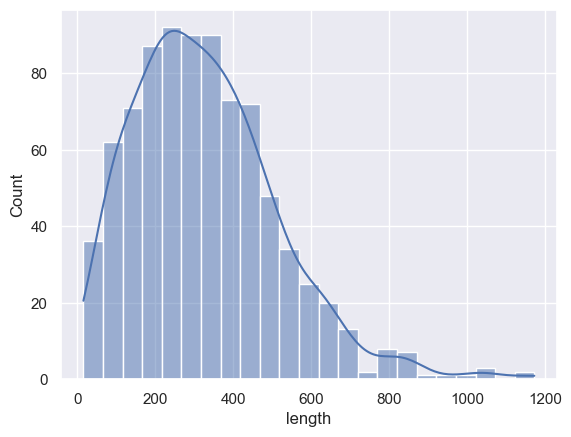

In [26]:
import seaborn as sns

chunk_df = pd.DataFrame(chunks,columns=['text'])
chunk_df['text'] = chunk_df['text'].astype('str')
chunk_df['length'] = chunk_df['text'].str.len()

sns.set(style="darkgrid")
sns.histplot(data=chunk_df, x='length', kde=True)

# Tokenisation

This approach extracts full sentenses from the input data - then converts these into n-grams for training.  All punctuation is removed.  This is probably not the best way to do this - as it's stopping the model understanding what a sentence is.  

Better to include key punctuation marks like full stop, comma, hyphen, colon etc as words/tokens in and of themselves.  This way, the model will learn to add sentence structure - and there will be an easier way to stop reading from the output - rather than just getting a set number of words, we could stop after the nth full stop, for example.

In [27]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# tokenizer = Tokenizer(num_words=2500, oov_token='<OOV>')
tokenizer = Tokenizer()
tokenizer.fit_on_texts(chunks)
word_index = tokenizer.word_index
total_words = len(word_index) + 1

max_length = 50

input_sequences = []

tokenizer_json = tokenizer.to_json()
with open('./data/nlp_models/tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

for line in chunks:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[max(i-max_length, 0):i+1]
        input_sequences.append(n_gram_sequence)

input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_length, padding='pre'))

xs = input_sequences[:,:-1]
labels = input_sequences[:,-1]
# One-hot encode the output, as the words are categorical
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

# Wrap in a Pandas Dataframe just for nicer display
pd.set_option('display.min_rows', 10)
pd.DataFrame(input_sequences)

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,52
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,52,13
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,52,13,14
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,52,13,14,297
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,52,13,14,297,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45029,0,0,0,0,0,0,0,0,0,0,...,0,0,0,9,114,57,11,50,5397,17
45030,0,0,0,0,0,0,0,0,0,0,...,0,0,9,114,57,11,50,5397,17,1
45031,0,0,0,0,0,0,0,0,0,0,...,0,9,114,57,11,50,5397,17,1,2710
45032,0,0,0,0,0,0,0,0,0,0,...,9,114,57,11,50,5397,17,1,2710,21


# Build the model

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_length - 1))
model.add(Bidirectional(LSTM(250)))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 47, 100)           539800    
                                                                 
 bidirectional_1 (Bidirectio  (None, 500)              702000    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 5398)              2704398   
                                                                 
Total params: 3,946,198
Trainable params: 3,946,198
Non-trainable params: 0
_________________________________________________________________


/Users/dan/Development/simple-prediction/.venv/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# Do some training

In [29]:
from datetime import datetime
import matplotlib.pyplot as plt
from IPython.display import clear_output

history_df = pd.DataFrame(columns=['loss', 'accuracy'])

run_count = 20
epochs_per_run = 100

for run in range(0, run_count):
    clear_output(wait=True)

    print(f"Starting Run {run}/{run_count}")
    # Use verbose=2 here to prevent progreess bars locking up jupyter after a few hours
    history = model.fit(xs, ys, epochs=epochs_per_run, verbose=2)
    
    dt = datetime.now() 
    model_filename = f"data/nlp_models/model_{dt.year}_{dt.month}_{dt.day}_{dt.hour}_{dt.minute}.h5"
    model.save(model_filename)

    history_df = pd.concat([history_df, pd.DataFrame(history.history)], ignore_index=True)

    plt.plot(history_df['accuracy'])
    plt.title(f'Model Training Progress - Run {run} of {run_count}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()

Starting Run 0/20
Epoch 1/100


2023-01-21 16:27:19.422067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-21 16:27:19.807138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-21 16:27:19.840501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-21 16:27:20.172859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-21 16:27:20.203037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1408/1408 - 57s - loss: 6.3728 - accuracy: 0.0999 - 57s/epoch - 40ms/step
Epoch 2/100


# See how well the replacement Dan is working

In [ ]:
seed_text = "lathe"
next_words = 20

word_lookup = {v: k for k, v in tokenizer.word_index.items()}

seed_texts = [
    "a data strategy is important because",
    "it flies really",
    "the diesel engine pumps out black smoke because",
    "this article is about",
    "supply for indicators comes from aux relay",
    "so we made one out of a chunk of",
    "if a train is delayed or cancelled",
    "here we use KSQL to create",
    "looks like there are four",
    "how much you invest in your data engineering capability",
    "i believe"
]
next_words = 30
max_length = 12

reverse_punctuation = {
    " ''fullstop''": ".",
    " ''comma''": ",",
    " ''bang''": "!",
    " ''eh''": "?",
    " ''endpara''": ""
}

seed_texts = [s.lower() for s in seed_texts]
for seed_text in seed_texts:
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_length-1, padding='pre')
        predicted = np.argmax(model.predict(token_list, verbose=0), axis=1)[0]
        output_word = word_lookup[predicted]
        seed_text += ' ' + output_word

        if output_word == "''endpara''":
            break

    for f, r in reverse_punctuation.items():
        seed_text = seed_text.replace(f, r)
    print(seed_text)
    

2023-01-20 11:45:25.681035: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-20 11:45:25.810352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-20 11:45:25.820982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


a data strategy is important because it is to say about the data round the select create a different process.
it flies really from rc model reviews for me the app i but the weather data.
the diesel engine pumps out black smoke because or however you run data, only solution. again, which the set after. its the code here or good
this article is about angularjs and its about teamcity. its not about npm or bower or any of the garage and running on a long to have years set to do. about
supply for indicators comes from aux relay bar 1 project on the aws customised the called weather level managed to demonstrate rest is youre to our weather data are, but even through here an overnight.
so we made one out of a chunk of data in the rest i be more than read the system. this part down on a different ingest and were to take the problem of us to build to
if a train is delayed or cancelled id for example ive switched jobs for have another coffee. on my face recognition into the simplest, no be from 